In [2]:
from models import train_predict,CondensedGoogLeNet
from models.train_predict import get_confusion_matrix
from data.data_processing import generate_dummy_data,DataHandler,get_training_data_from_path
from config.hyperparams import GoogleNet_hyperparams

import tensorflow as tf
import pandas as pd
import numpy as np
import os

%load_ext autoreload
%autoreload 2
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
folder_for_samples = 'data/cnn_samples/regular'

# Data Processing

## Get stock data in Handler object

In [14]:
handler = DataHandler(encoding_method='GADF', window_len=64, image_size=16, retrain_freq=5,
                 start_date = 20150102, end_date= 20200102, frac_of_stocks=0.1,
                stock_data_dir_path= 'data/stock_data',
                 dir_for_samples=folder_for_samples, nb_of_stocks_by_file=50,
                      kwargs_target_methods = {'up_return':0.011,'down_return':-0.0125}
                 )

In [15]:
handler.get_df_data()

Textarea(value='', layout=Layout(border='1px solid #999999', height='200px', width='100%'))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


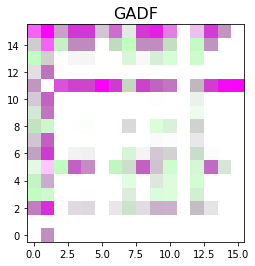

In [16]:
handler.show_image(handler.df_data)

## Builds images and targets and creates pickles
+ Be careful for the folder name (specified in handler object), this function will delete all files in this folder before dumping pickles

In [17]:
handler.build_and_dump_images_and_targets()

Textarea(value='', layout=Layout(border='1px solid #999999', height='200px', width='100%'))

# Training

## Retrieve data from the specified folder

In [4]:
%%time

X_train, X_val, X_test, Y_train, Y_val, Y_test = get_training_data_from_path(samples_path=folder_for_samples,
                                targets_type='VWAP_targets',
                                train_val_size=2 / 3.,
                                train_size=0.75,
                                logger_env='Training')


Textarea(value='', layout=Layout(border='1px solid #999999', height='200px', width='100%'))

Wall time: 1.37 s


## Build the neural network object

## Train the network 

In [12]:
shape_x,shape_y = list(X_train.shape),list(Y_train.shape)
shape_x[0],shape_y[0] = None,None

GoogleNet_hyperparams.update({'learning_rate':0.003,'dropout':0.20})

network = CondensedGoogLeNet(shape_x=shape_x,shape_y=shape_y,hyperparams=GoogleNet_hyperparams)

n_test = 15000
checkpoints_folder = 'model_checkpoints'
checkpoint_prefix = 'ckpt'
model_checkpoints_path = os.path.join(checkpoints_folder,checkpoint_prefix)

X_train1, X_val1, Y_train1, Y_val1 =  X_train[:n_test], X_val[:n_test], Y_train[:n_test], Y_val[:n_test]




path_restore = (tf.train.latest_checkpoint('model_checkpoints') or '')+'.meta'
GN_pred, GN_training_loss, GN_val_loss = train_predict(X=X_train1, Y=Y_train1, batch_size=30, valX=X_val1, valY=Y_val1,
                                                       model_ckpt_path=model_checkpoints_path, is_bayesian=True,
                                                       epochs=2, net=network,save_step =2,cost_sensitive_loss=False,restore=True,
                                                       model_ckpt_path_to_restore=path_restore)

Textarea(value='', layout=Layout(border='1px solid #999999', height='200px', width='100%'))

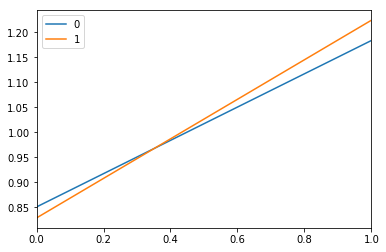

In [11]:
pd.DataFrame([GN_training_loss,GN_val_loss]).plot()

In [29]:
network.x

<tf.Tensor 'CondensedGoogLeNet/x:0' shape=(?, 16, 16, 4) dtype=float32>

# Backtest

In [ ]:
# TODO

# Little tests section

In [30]:
import tensorflow as tf

In [8]:
tf.train.latest_checkpoint('model_checkpoints')

'model_checkpoints\\ckpt-266'

In [13]:

# with tf.variable_scope('test',reuse=tf.AUTO_REUSE):
#     network2 = CondensedGoogLeNet(shape_x=shape_x,shape_y=shape_y,hyperparams=GoogleNet_hyperparams)
#     network2.build_operations()
sess=tf.Session()    
#First let's load meta graph and restore weights
# saver = tf.train.import_meta_graph('model_checkpoints/ckpt1-266.meta')
saver = tf.train.import_meta_graph('model_checkpoints/ckpt-26.meta')
saver.restore(sess,tf.train.latest_checkpoint('model_checkpoints'))

INFO:tensorflow:Restoring parameters from model_checkpoints\ckpt-26


In [14]:
graph = tf.get_default_graph()
# w1 = graph.get_tensor_by_name("w1:0")
# w2 = graph.get_tensor_by_name("w2:0")
# feed_dict ={w1:13.0,w2:17.0}



+ CondensedGoogLeNet/loss/Mean gets the loss
+ CondensedGoogLeNet/Adam gets the optimizer
+ CondensedGoogLeNet/accuracy/Mean gets the accuracy
    + we can get the validation error just after
+ CondensedGoogLeNet/Merge/MergeSummary gets the summary op
+ CondensedGoogLeNet/init gets init_op
+ 

In [15]:
output = graph.get_tensor_by_name('CondensedGoogLeNet/output:0')
train_op = graph.get_tensor_by_name('CondensedGoogLeNet/minimize:0')
x = graph.get_tensor_by_name('CondensedGoogLeNet/x:0')
y = graph.get_tensor_by_name('CondensedGoogLeNet/y:0')
global_step = graph.get_tensor_by_name('CondensedGoogLeNet/global_step:0')
# loss = graph.get_tensor_by_name('CondensedGoogLeNet/loss/Mean:0')

In [18]:
pred = sess.run([train_op,global_step],feed_dict={x:X_val[:100],y:Y_val[:100]})

In [19]:
pred

[28, 28]

In [62]:
network.optimizer

<tf.Operation 'CondensedGoogLeNet/minimize' type=AssignAdd>

In [99]:
# train_op = graph.get_tensor_by_name('CondensedGoogLeNet/minimize:0')


In [49]:
train_op

<tf.Tensor 'CondensedGoogLeNet/Adam:0' shape=() dtype=int32_ref>

In [47]:
pred

408

In [48]:
pred = sess.run(output,feed_dict={x:X_val1[:15]})
pred

array([[0.54534346, 0.31630963, 0.13834698],
       [0.24215752, 0.27100408, 0.48683837],
       [0.19895326, 0.2448365 , 0.5562103 ],
       [0.46735036, 0.3460878 , 0.18656184],
       [0.28557023, 0.5997592 , 0.11467056],
       [0.3116192 , 0.43605033, 0.25233048],
       [0.21186991, 0.61546487, 0.17266521],
       [0.23539183, 0.67194796, 0.09266017],
       [0.12098232, 0.7968117 , 0.08220595],
       [0.13915536, 0.7540392 , 0.10680544],
       [0.26458594, 0.61498356, 0.1204305 ],
       [0.2907207 , 0.5771785 , 0.13210084],
       [0.18505928, 0.5521796 , 0.26276112],
       [0.20635134, 0.5497223 , 0.2439263 ],
       [0.28695482, 0.5000306 , 0.2130146 ]], dtype=float32)

In [20]:
saver.save(sess,'model_checkpoints/test_restore')

'model_checkpoints/test_restore'

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001EB8140E128>]],
      dtype=object)

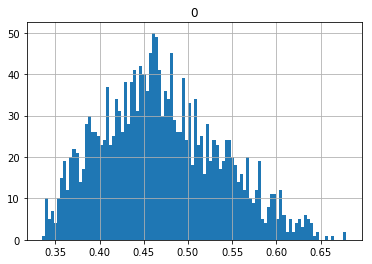

In [61]:
pd.DataFrame(np.max(pred,axis=1)).hist(bins=100)

In [46]:
pred[:5]

array([[0.37601736, 0.38016203, 0.24382067],
       [0.33472654, 0.37284032, 0.2924331 ],
       [0.35309193, 0.30750227, 0.33940583],
       [0.3471133 , 0.32821226, 0.3246745 ],
       [0.3240848 , 0.3507759 , 0.3251393 ]], dtype=float32)

In [42]:
GN_pred[:5]

array([[0.38847148, 0.36652684, 0.24500167],
       [0.32993904, 0.42600474, 0.24405627],
       [0.32316726, 0.3760524 , 0.30078036],
       [0.33141774, 0.36307806, 0.3055042 ],
       [0.36576766, 0.33067912, 0.30355325]], dtype=float32)

In [43]:
Y_val[:5]

array([[0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0]])

In [16]:
pred.shape

(1885, 3)

In [ ]:
tf.reset_default_graph()

# Create some variables.
v1 = tf.get_variable("v1", shape=[3])
v2 = tf.get_variable("v2", shape=[5])

# Add ops to save and restore all the variables.
saver = tf.train.Saver()

# Later, launch the model, use the saver to restore variables from disk, and
# do some work with the model.
with tf.Session() as sess:
  # Restore variables from disk.
  saver.restore(sess, "/tmp/model.ckpt")
  print("Model restored.")
  # Check the values of the variables
  print("v1 : %s" % v1.eval())
  print("v2 : %s" % v2.eval())

In [ ]:
tf.train.latest_checkpoint

In [3]:
tf.train.import_meta_graph

5